<a href="https://colab.research.google.com/github/ufrpe-bcc-ia/material-aulas/blob/master/aprendizagem_maquina/06_ExploracaoDados_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploração de dados: Pandas
===
***

##Introdução

Vamos usar um conjunto de dados razoavelmente grande e confuso de um objeto de origem familiar e depois prepará-lo para análise usando o algoritmo Random Forest.

Usaremos um conjunto de dados de acelerômetro de celular e leituras de giroscópio para criar um modelo preditivo. O conjunto de dados é encontrado no formulário R Data [1] no Amazon S3 e formulário bruto no Repositório UCI [2]. As leituras do conjunto de dados codificam dados sobre a orientação do telefone móvel e o movimento do usuário do telefone.

O sujeito é conhecido por fazer uma das seis atividades - sentado, em pé, deitado, andando, andando e andando.

## Métodos

Nosso objetivo é prever, dado um ponto de dados, qual atividade eles estão fazendo.
Estabelecemos a nós mesmos um objetivo de criar um modelo com variáveis **compreensíveis**, em vez de um modelo de **caixa preta**. 
Modelo de caixa preta consiste basicamente de apenas variáveis e coeficientes. Dado um novo padrão, ele é apresentado ao modelo, que por sua vez dá apenas uma resposta. Isso geralmente funciona, mas é simplesmente muita "mágica" para nos ajudar a construir nossa intuição ou nos dar qualquer oportunidade de usar nosso conhecimento de domínio.

Então, vamos abrir a caixa um pouco e vamos usar o conhecimento de domínio combinado com o poder massivo da Random Forests quando tivermos alguma intuição. Descobrimos que, a longo prazo, essa é uma abordagem muito mais satisfatória e, ao que parece, muito mais poderosa.

Vamos reduzir a quantidade de variáveis independentes para 36 variáveis, usando apenas o conhecimento do domínio e, em seguida, usar o Random Forest para prever a variável "atividade". Este pode não ser o melhor modelo do ponto de vista da precisão, mas queremos entender o que está acontecendo e, a partir dessa perspectiva, acaba sendo muito melhor.

Usamos medidas de precisão Positivo e Negativo Valor de Previsão, Sensibilidade e Especificidade para classificar nosso modelo.

### Leitura e visualização inicial
Os dados podem ser lidos a partir de uma URL diretamente em um pandas dataframe. 

In [0]:
%pylab inline
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/nborwankar/LearnDataScience/master/datasets/samsung/samsungdata.csv')

Populating the interactive namespace from numpy and matplotlib


Utilize o atributo `df.columns` para visualizar as colunas existentes no dataframe lido

Utilize as funções `head()` e `tail()` para visualizar o início e o fim do dataframe, respectivamente

In [0]:
# head

In [0]:
# tail

### Limpeza
* O conjunto de dados fornecido contém dados de atividade para 21 indivíduos.
* O conjunto de dados tem 7.352 linhas com 561 colunas de dados numéricos, mais 2 colunas "subject", um número inteiro e "activity", uma string.
* Como temos 563 colunas no total, vamos dispensar a etapa de criar um dicionário de dados formal e consultar o arquivo [feature_info.txt](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

* A exploração inicial dos dados mostra que o texto do nome da coluna está sujo com vários problemas:
  * Nomes de coluna duplicados - várias ocorrências.
  * Inclusão de () nos nomes das colunas.
  * Parênteses extra ) em alguns nomes de colunas.
  * Inclusão de "-" nos nomes das colunas.
  * Inclusão de vários "," nos nomes das colunas
  * Muitos nomes de colunas contêm "BodyBody", que supomos ser um erro de digitação.

### Exercício
Execute cada uma das atividades de limpeza de dados acima no conjunto de dados, utilizando as funções do pandas para isso.

* Identifique e remova nomes de coluna duplicados - várias ocorrências.
* Identifique e corrija a inclusão de () nos nomes das colunas. Como você vai consertar isso?
* Identifique e corrija o extra ) em alguns nomes de coluna. Como você vai consertar isso?
* Identifique e corrija a inclusão de "-" nos nomes das colunas. Como você vai consertar isso?
* Identifique e corrija a inclusão de vários "," nos nomes das colunas. Como você vai consertar isso?
* Identifique e corrija nomes de coluna contendo “BodyBody”.


### Redução de Variáveis

Antes de prosseguirmos, é muito importante ler com calma o arquivo [features_info.txt](https://github.com/nborwankar/LearnDataScience/blob/master/datasets/ucihar/features_info.txt). Este arquivo descreve cada característica, a sua importância física e também descreve recursos que são derivados de dados brutos, fazendo alguma média ou amostragem ou alguma operação que fornece resultados numéricos.

Nós queremos olhar para

a) todos os nomes das variáveis
b) quantidades físicas

Uma vez que passamos algum tempo fazendo tudo isso, podemos extrair algumas diretrizes úteis usando a compreensão física e o bom senso.

* Em atividades estáticas (sentar, repousar, deitar) a informação de movimento não será muito útil.
* Nas atividades dinâmicas (3 tipos de caminhada) o movimento será significativo.
* Variáveis de **ângulo** serão úteis tanto na diferenciação de “mentira vs posição” quanto “subida vs descida”.
* As variáveis **Acceleration** e **Jerk** são importantes para distinguir vários tipos de movimento enquanto se filtram tremores aleatórios enquanto estáticos.
* As variáveis **mag** e **angle** contêm as mesmas informações que as variáveis **XYZ** (= fortemente correlacionadas)
* Escolhemos nos concentrar nas últimas, pois são mais simples de raciocinar.
* Este é um ponto muito importante para entender, pois resulta na eliminação de algumas centenas de variáveis.
* Ignoramos as variáveis **band**, pois não temos uma maneira simples de interpretar o significado e relacioná-las às atividades físicas.
* -mean e -std são importantes, -skewness e -kurtosis também podem ser, portanto, incluímos todos estes.
* Veja que as variáveis têm prefixos / sufixos X, Y, Z e o Android Developer Reference [3] nos fornece o referencial específico com o qual eles são medidos. Eles são componentes vetoriais de jerk e aceleração, os ângulos são medidos em relação à direção da gravidade ou, mais precisamente, a aceleração do vetor devido à gravidade. Usamos essa informação e a combinamos com alguma intuição sobre movimento, velocidade, aceleração, etc.

Observe o histograma da variável `tBodyAccMag-mean` e como ela se correlaciona bem com a atividade:

()


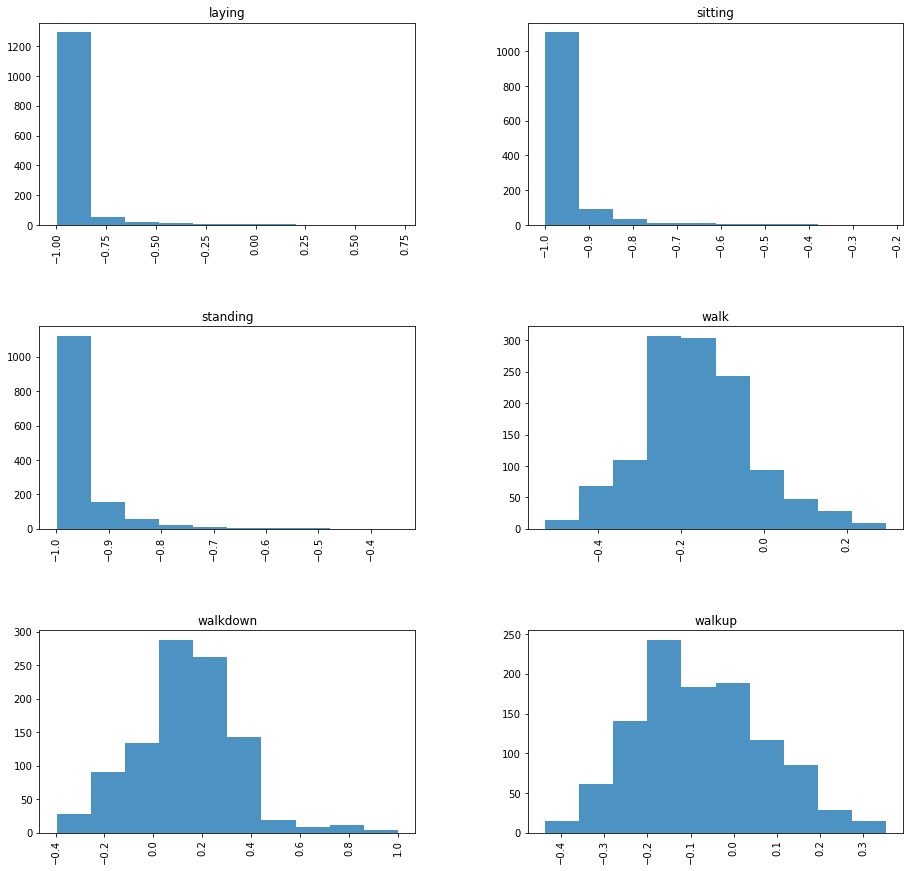

In [0]:
df.loc[:,['tBodyAccMag-mean()','activity']].hist(by = "activity", alpha=0.8, figsize=(15,15))
print()

Utilize outras funções de exploração e visualização do pandas para analisar a base.

### Eliminando variáveis (confounders)

Ao eliminar as variáveis -X -Y -Z (coordenadas cartesianas), removemos um grande número de variáveis de confusão, pois elas têm informações fortemente correlacionadas com Magnitude + Ângulo (coordenadas polares). Ainda pode haver algumas influências confusas, mas os efeitos remanescentes são difíceis de interpretar.

Do senso comum, vemos outras variáveis -min, -max, -mad têm correlações com a média / std, então descartamos todos esses confundidores também.
O número de variáveis é agora reduzido para 37, conforme veremos a seguir.

### Renomeando

Renomearemos algumas variáveis para facilitar a leitura da base. Removemos "Body" e "Mag" e mapeamos ‘mean’ to Mean and ‘std’ to SD

Por exemplo:

* tAccBodyMag-mean -> tAccMean  
* fAccBodyMag-std -> fAccSD  
* etc.  


## Resultados

O conjunto reduzido de variáveis selecionadas com nomes transformados é agora (com agrupamentos significativos):  

* tAccMean, tAccSD tJerkMean, tJerkSD
* tGyroMean, tGyroSD tGyroJerkMean, tGyroJerkSD
* fAccMean, fAccSD, fJerkMean, fJerkSD,
* fGyroMean, fGyroSD, fGyroJerkMean, fGyroJerkSD,
* fGyroMeanFreq, fGyroJerkMeanFreq fAccMeanFreq, fJerkMeanFreq
* fAccSkewness, fAccKurtosis, fJerkSkewness, fJerkKurtosis
* fGyroSkewness, fGyroKurtosis fGyroJerkSkewness, fGyroJerkKurtosis
* angleAccGravity, angleJerkGravity angleGyroGravity, angleGyroJerkGravity
* angleXGravity, angleYGravity, angleZGravity
* subject, activity  

## Conclusão

Utilize a função `df.to_csv()` do pandas para salvar as suas modificações na base. Salve este notebook do colab no seu google Drive ou (melhor) no github (crie um repositório para isso). Os dados serão utilizados no próximo exercício.

## Referências

[1] <https://spark-public.s3.amazonaws.com/dataanalysis/samsungData.rda>   
[2] Human Activity Recognition Using Smartphones <http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones  
[3] Android Developer Reference <http://developer.android.com/reference/android/hardware/Sensor.html>  
[4] Random Forests <http://en.wikipedia.org/wiki/Random_forest>  
[5] Code for computation of error measures <https://gist.github.com/nborwankar/5131870>  

Obs. Este tutorial é uma adaptação do material disponível em https://github.com/nborwankar/LearnDataScience
